# Flight Delay Prediction Dataset: Airline Delays

## Project Overview

Flight delays are a major inconvenience for travelers and a costly challenge for airlines. This project analyzes U.S. airline operational data to understand key factors influencing flight delays and build a predictive machine learning model.

## Project Goals

- Perform exploratory data analysis (EDA) on flight delay data.
- Identify correlations between flight attributes and delays.
- Visualize delay patterns across airlines, days of the week, and flight durations.
- Build and evaluate a machine learning model to predict the likelihood of flight delays.

Dataset Source: Kaggle – Flight Delay Prediction Dataset: Airline Delays


## Importing Required Libraries

We start by importing the necessary Python libraries for data manipulation, visualization, and machine learning.


In [1]:
pip install imbalanced-learn


   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

## Loading the Dataset

We load the flight dataset and examine its structure, data types, and missing values.


In [3]:
file_path = r"C:\Users\slind\OneDrive\Bureau\Flight Delays and Cancellations 2015_Kaggle\archive\Airlines.csv"
df = pd.read_csv(file_path)

df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


## Basic Structure & Data Cleaning
In this section, we perform an initial inspection of the dataset and clean it to prepare for analysis and modeling.
- Shape & Data Types: Understand the number of rows and columns, and review data types for each feature.
- Missing Values: Identify columns with missing values to decide on imputation or removal.
- Target Variable Inspection: Analyze the distribution of the target variable (Delay) to assess class imbalance.
- Drop Non-Informative Columns: Remove unnecessary columns such as id and Flight that don't contribute to the prediction task.
- This ensures we start with a consistent and clean dataset for further exploration and modeling.

In [4]:
df.drop(['DayOfWeek', 'id', 'Flight', 'Delay'], axis=1).describe()

,Time,Length
count,539383.000000,539383.000000
mean,802.728963,132.202007
std,278.045911,70.117016
min,10.000000,0.000000
25%,565.000000,81.000000
50%,795.000000,115.000000
75%,1035.000000,162.000000
max,1439.000000,655.000000


In [5]:
# Dataset overview
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nClass distribution:\n", df['Delay'].value_counts(normalize=True))

# Drop non-informative columns
df.drop(['id', 'Flight'], axis=1, inplace=True)

# Encode categorical variables for plotting correlation
encoded_df = df.copy()
for col in ['Airline', 'AirportFrom', 'AirportTo']:
    encoded_df[col] = encoded_df[col].astype('category').cat.codes


Shape of dataset: (539383, 9)

Data types:
 id              int64
Airline        object
Flight          int64
AirportFrom    object
AirportTo      object
DayOfWeek       int64
Time            int64
Length          int64
Delay           int64
dtype: object

Missing values:
 id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

Class distribution:
 Delay
0    0.554558
1    0.445442
Name: proportion, dtype: float64


## Correlation Matrix

This heatmap shows the correlation between numerical features. Encoding was applied to categorical variables for this purpose. It helps us understand which variables might impact delays.


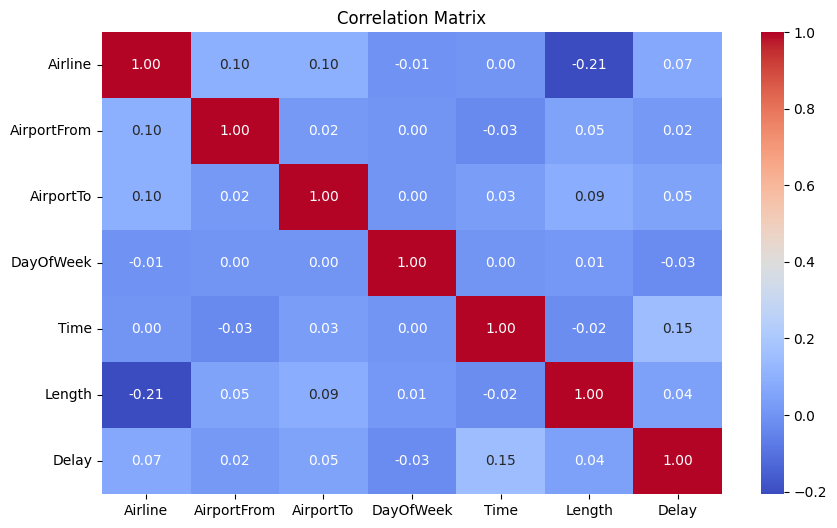

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(encoded_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Delay Distribution

This plot shows how frequently delays occur. The target variable `Delay` is binary:
- `0`: No Delay
- `1`: Delayed Flight

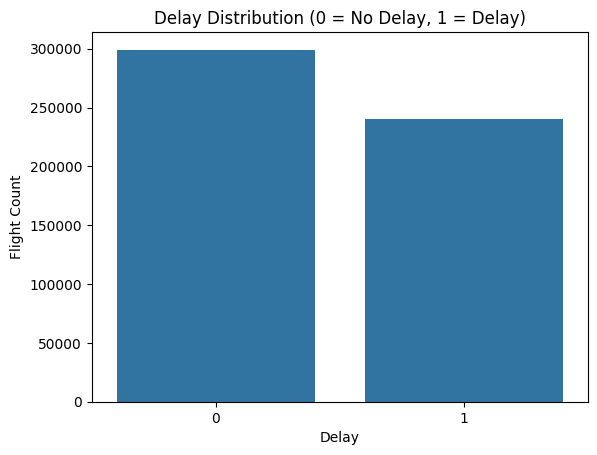

In [7]:
sns.countplot(x='Delay', data=df)
plt.title("Delay Distribution (0 = No Delay, 1 = Delay)")
plt.xlabel("Delay")
plt.ylabel("Flight Count")
plt.show()

## Flight Duration vs Delay

We use a boxplot to analyze whether longer or shorter flights are more prone to delays.

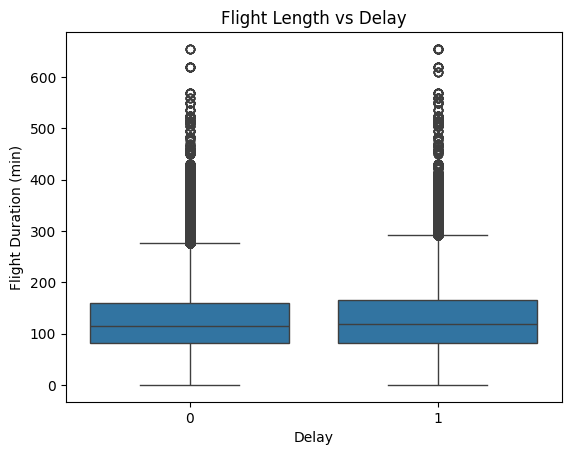

In [8]:
sns.boxplot(x='Delay', y='Length', data=df)
plt.title("Flight Length vs Delay")
plt.xlabel("Delay")
plt.ylabel("Flight Duration (min)")
plt.show()

## Delay Rate by Airline

This bar plot shows which airlines tend to have more delayed flights. It helps in benchmarking performance across carriers.

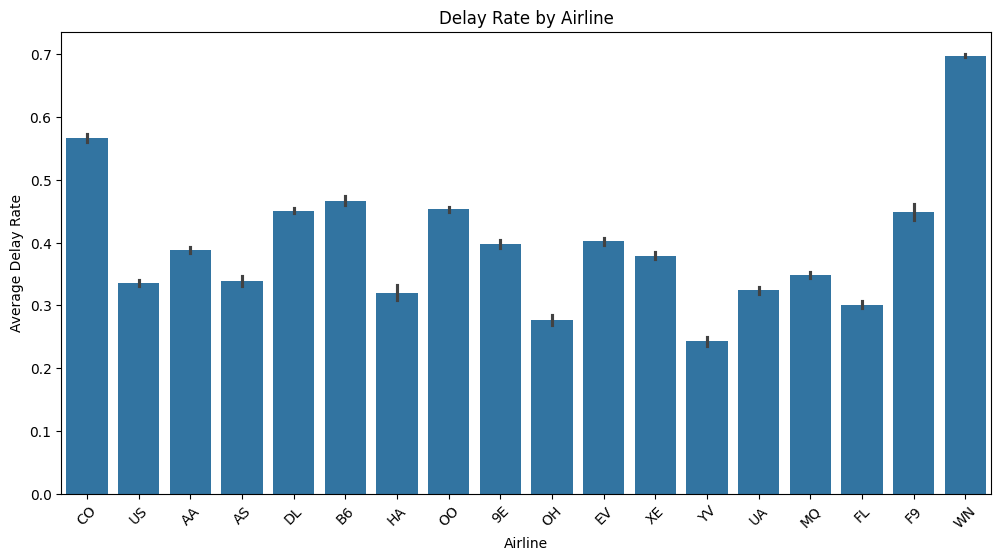

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Airline', y='Delay', data=df, estimator=lambda x: sum(x)/len(x))
plt.title("Delay Rate by Airline")
plt.ylabel("Average Delay Rate")
plt.xlabel("Airline")
plt.xticks(rotation=45)
plt.show()

## Delay Rate by Day of the Week

This chart illustrates trends in delays across different days. Are certain weekdays more prone to delays?

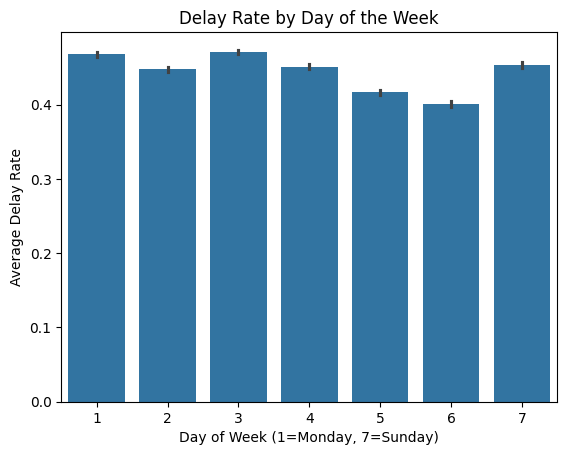

In [10]:
sns.barplot(x='DayOfWeek', y='Delay', data=df)
plt.title("Delay Rate by Day of the Week")
plt.ylabel("Average Delay Rate")
plt.xlabel("Day of Week (1=Monday, 7=Sunday)")
plt.show()

## Machine Learning: Model Building and Evaluation
In this section, we develop and evaluate three machine learning models to predict flight delays. The target variable Delay is binary (0 = No Delay, 1 = Delay).

Before training, we split the encoded dataset into features (X) and target (y). We use an 80/20 train-test split and apply stratification to preserve class balance.

In [11]:
# Define features and target from encoded_df
X = encoded_df.drop('Delay', axis=1)
y = encoded_df['Delay']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 1. Logistic Regression
Logistic Regression is a simple and interpretable baseline model used for binary classification.

In [12]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Report (with Class Weight):")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Logistic Regression Report (with Class Weight):
              precision    recall  f1-score   support

           0       0.63      0.58      0.60     59824
           1       0.52      0.57      0.55     48053

    accuracy                           0.58    107877
   macro avg       0.58      0.58      0.57    107877
weighted avg       0.58      0.58      0.58    107877

Confusion Matrix:
 [[34616 25208]
 [20492 27561]]


## 2. Random Forest Classifier
Random Forest is an ensemble learning method that builds multiple decision trees and merges them to improve accuracy and control overfitting.

In [13]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Report (with Class Weight):")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Report (with Class Weight):
              precision    recall  f1-score   support

           0       0.65      0.64      0.65     59824
           1       0.56      0.58      0.57     48053

    accuracy                           0.61    107877
   macro avg       0.61      0.61      0.61    107877
weighted avg       0.61      0.61      0.61    107877

Confusion Matrix:
 [[38507 21317]
 [20398 27655]]


## 3.  Gradient Boosting Classifier
Gradient Boosting builds an additive model in a forward stage-wise fashion. It is highly effective for classification tasks.

In [14]:
# Compute class weights manually
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Report (with Sample Weights):")
print(classification_report(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

Gradient Boosting Report (with Sample Weights):
              precision    recall  f1-score   support

           0       0.67      0.70      0.68     59824
           1       0.60      0.58      0.59     48053

    accuracy                           0.64    107877
   macro avg       0.64      0.64      0.64    107877
weighted avg       0.64      0.64      0.64    107877

Confusion Matrix:
 [[41624 18200]
 [20321 27732]]


## Model Evaluation Summary

| Model               | Accuracy | Precision (Delay=1) | Recall (Delay=1) | F1-Score (Delay=1) |
| ------------------- | -------- | ------------------- | ---------------- | ------------------ |
| Logistic Regression | 0.58     | 0.52                | 0.57             | 0.55               |
| Random Forest       | 0.61     | 0.56                | 0.58             | 0.57               |
| Gradient Boosting   | 0.64     | 0.60                | 0.59             | 0.59               |

Observations:

Gradient Boosting Classifier achieved the best overall performance in terms of both accuracy and F1-score.
Logistic Regression, while interpretable, underperformed compared to ensemble methods.
All models improved significantly after addressing class imbalance using class_weight='balanced'.

## Recommendations for Further Improvement
To enhance the model's ability to predict delays more accurately, consider the following data enrichment and modeling strategies:

1. Feature Engineering / Enrichment
Weather data: Add weather conditions (rain, fog, temperature, etc.) at departure and arrival airports.
Holiday indicators: Mark national holidays and peak travel periods (e.g., Thanksgiving, Christmas).
Airport traffic: Include number of flights per hour/day at the departure and arrival airports.
Time of day buckets: Segment Time into parts of the day (e.g., morning, afternoon, evening, night).
Airline on-time history: Use historical airline performance metrics as an additional feature.

2. Advanced Modeling
Try more advanced models like:
LightGBM
CatBoost (especially effective with categorical features)
Apply hyperparameter tuning using GridSearchCV or RandomizedSearchCV.

3. Pipeline and Evaluation Enhancements
Use Stratified K-Fold Cross-Validation for robust performance estimation.

Explore threshold tuning on prediction probabilities to optimize recall or precision depending on business priority (e.g., minimizing customer frustration vs. cost of false alarms).

## Conclusion
The project successfully demonstrated:
- Data exploration and preprocessing of airline delay data.
- Identification of class imbalance and effective mitigation using class_weight.
- Comparison of baseline and ensemble classifiers for delay prediction.
Best Performer: Gradient Boosting with class weights — balanced accuracy and good F1-score.

However, model performance remains moderate due to limited features. By enriching the dataset with external real-world signals (e.g., weather, airport load, seasonality), the predictive accuracy could improve significantly and support more reliable flight delay predictions in real-time applications.